In [2]:
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
os.getcwd()

'/Users/nepal/Documents/synapthesis/Luglio23sett'

In [4]:
data_directory = "/Users/nepal/Documents/synapthesis/synData28June"
lotti_fn = "export_lotti_veneto_2016_2018_giulio.csv"
vincitori_fn = "export_vincitori_veneto_2016_2018_giulio.csv"

lotti = pd.read_csv(path.join(data_directory, lotti_fn))
vincitori = pd.read_csv(path.join(data_directory, vincitori_fn))

lotti.data_inizio = pd.to_datetime(lotti.data_inizio, yearfirst=True)
lotti.data_fine = pd.to_datetime(lotti.data_fine, yearfirst=True)
lotti = lotti.rename(columns={"md5": "tipo_acquirente"})

vincitori = vincitori.rename(columns={"md5":"tipo_fornitore"})

In [5]:
print("percentuale di NaNs sul totale di transazioni")
np.sum(lotti.isna(), axis=0) / lotti.shape[0] * 100

percentuale di NaNs sul totale di transazioni


id_lotto                    0.000000
oggetto                     0.003905
id_scelta_contraente        0.018364
id_cpv                     93.305836
importo                     0.117678
importo_base_asta          98.106168
importo_liquidato           5.936589
data_inizio                 0.000000
data_fine                   5.623026
data_inferita_calcolata     0.000000
id_lsf                      3.534259
id_mod_realizz             95.326951
id_forma_giuridica          0.000000
tipo_acquirente             0.000000
dtype: float64

# Assunzioni 
analizziamo i soli contratti che 
1. hanno un solo vincitore, cioè non sono un hanno RTI (raggruppamento temporaneo di impresa), ossia scartiamo quelle gare che hanno più di un vincitore.
3. Qualora queste avessero l'importo di base d'asta, ma non l'importo, sostituiamo l'importo base d'asta con l'importo.
4. sostituiamo le date con la differenza tra data di inizio e fine.
5. scartiamo la colonna oggetto perché il contenuto rilevante verrà sostituito dal CPV
5. scartiamo la colonna importo liquidato 
6. scartiamo la colonna id_mod_realizz perché eccessivamente incompleto
7. scartiamo la colonna importi base d'asta perché poco rilevanti
7. scartiamo la colonna data_inferita_calcolata perché resa irrilevante dal punto 3
8. scartiamo le tutte transazioni aventi almeno un dato assente 

In [8]:
def replace_col1_with_col2(df, col1, col2):
    """
    replace NAs of col1 with col2 values
    """
    # create a series wih only column1 NAs
    s = df[col1][df[col1].isna()]
    # replace those values with column2 values
    s = df[col2][df[col1].isna()]
    # replace the NAs values in col1 in df at the indices of series s
    df.loc[s[s.notna()].index, col1] = s[s.notna()]
    return df, s

lotti2, s= replace_col1_with_col2(lotti, "importo", "importo_base_asta")
lotti2.importo[lotti.importo.isna()]

726      NaN
1091     NaN
2618     NaN
6103     NaN
6433     NaN
          ..
944512   NaN
946152   NaN
947009   NaN
947012   NaN
947099   NaN
Name: importo, Length: 1108, dtype: float64

In [11]:
lotti.

1108

In [5]:
# Qualora queste avessero l'importo di base d'asta, ma non l'importo,
# sostituiamo l'importo base d'asta con l'importo. 
importi = lotti.importo[lotti.importo.isna()]
importi = lotti.importo_base_asta[lotti.importo.isna()]
importi[importi.notna()]
lotti.loc[importi[importi.notna()].index, "importo"] = importi[importi.notna()]
lotti.loc[importi[importi.notna()].index, "importo"]

147573    2285340.00
180601    1043088.90
246768     300000.30
367383       3738.04
600605    1358171.52
640729    1372574.00
740602       3890.00
Name: importo, dtype: float64

In [6]:
# scartiamo tutte le transazioni aventi almeno un valore nullo
lotti = lotti.dropna()

In [7]:
# aggiugiamo la durata del contratto
lotti["durata"] = lotti.data_fine - lotti.data_inizio

In [8]:
# scartiamo le colonne importo liquidato e oggetto.
lotti = lotti.drop(columns = [
    "oggetto", "importo_liquidato", "importo_base_asta", 
    "id_mod_realizz", "data_inferita_calcolata", "data_fine"
])

In [9]:
lotti.loc[:, "id_scelta_contraente"] = lotti.id_scelta_contraente.astype("int")
lotti.loc[:, "id_cpv"] = lotti.id_cpv.astype("int")
lotti.loc[:, "id_lsf"] = lotti.id_lsf.astype("int")
lotti.dtypes

id_lotto                          int64
id_scelta_contraente              int64
id_cpv                            int64
importo                         float64
data_inizio              datetime64[ns]
id_lsf                            int64
id_forma_giuridica                int64
tipo_acquirente                  object
durata                  timedelta64[ns]
dtype: object

## vincitori

In [10]:
# percentuale di 
np.sum(vincitori.isna(), axis=0) / vincitori.shape[0] * 100

id_lotto               0.000000
ruolo                 99.515753
id_be                  0.000000
id_forma_giuridica     0.000000
tipo_fornitore         0.106399
dtype: float64

In [11]:
vincitori = vincitori.drop(columns=["ruolo"])

In [12]:
# rimuovo i vincitori duplicati (quelli aventi RTI raggruppamento temporaneo di imprese)
vincitori = vincitori[~ vincitori.duplicated(keep=False)]

In [13]:
# rimuoviamo le transazioni aventi almeno un valore nullo
vincitori = vincitori.dropna()

# merge lotti vincitori

In [14]:
# hanno un solo vincitore, cioè non sono un hanno RTI (raggruppamento 
# temporaneo di impresa), ossia scartiamo quelle gare che hanno più 
# di un vincitore.

In [15]:
df = lotti.merge(vincitori, on="id_lotto", how="inner", suffixes=("_acquirente", "_fornitore"))
df

,id_lotto,id_scelta_contraente,id_cpv,importo,data_inizio,id_lsf,id_forma_giuridica_acquirente,tipo_acquirente,durata,id_be,id_forma_giuridica_fornitore,tipo_fornitore
0,10692164,6,6724,88200.00,2018-05-21,1,15,47a78836496a7a97994acb6aef0d8cbf,178 days,252044,154,1f2eac73c875ee65907ba4d8681a7d2a
1,4667236,4,7019,291190.00,2017-06-12,1,18,47a78836496a7a97994acb6aef0d8cbf,96 days,122968,154,1f2eac73c875ee65907ba4d8681a7d2a
2,6212751,4,6470,822048.07,2016-06-14,1,15,47a78836496a7a97994acb6aef0d8cbf,87 days,100221,154,1f2eac73c875ee65907ba4d8681a7d2a
3,565198,4,7146,62500.00,2017-10-09,1,15,47a78836496a7a97994acb6aef0d8cbf,36 days,89066,154,1f2eac73c875ee65907ba4d8681a7d2a
4,2558444,22,6725,385000.00,2016-09-21,1,15,47a78836496a7a97994acb6aef0d8cbf,86 days,312318,154,1f2eac73c875ee65907ba4d8681a7d2a
...,...,...,...,...,...,...,...,...,...,...,...,...
4174,14781691,4,6558,163838.88,2018-10-31,1,145,4c9f18d34d17b903f078e45bc25d54b1,242 days,2356014,154,1f2eac73c875ee65907ba4d8681a7d2a
4175,14781691,4,6558,163838.88,2018-10-31,1,145,4c9f18d34d17b903f078e45bc25d54b1,242 days,936101,152,1f2eac73c875ee65907ba4d8681a7d2a
4176,14781691,4,6558,163838.88,2018-10-31,1,145,4c9f18d34d17b903f078e45bc25d54b1,242 days,562300,152,1f2eac73c875ee65907ba4d8681a7d2a
4177,9051293,22,6725,149900.00,2018-06-04,1,15,47a78836496a7a97994acb6aef0d8cbf,149 days,86708,154,1f2eac73c875ee65907ba4d8681a7d2a


# feature extraction
1. fatturato (= somma degli importi) mediano della business entity per anno (caratterizzo la business entity)
3. fatturato mediano erogato da una centrale di committenza (caratterizzo la centrale di committenza)
2. durata del contratto (già fatto)

In [16]:
fatturato_be_year = df.groupby(["id_be", df.data_inizio.map(lambda x : x.year)]).sum().importo
fatturato_be_year = fatturato_be_year.unstack()
fatturato_be_year

data_inizio,2016,2017,2018
id_be,,,
485,893143.83,NaN,43336.82
591,683466.15,NaN,NaN
593,NaN,125437.5,NaN
1003,NaN,51500.0,NaN
1131,385643.37,NaN,NaN
...,...,...,...
2797425,NaN,NaN,136000.00
2797427,NaN,NaN,136000.00
2849485,NaN,228720.0,NaN


non voglio introdurre NaN nel dataset, quindi utilizzerò il valore mediano (medio in questo caso, dato che corrispondo)

In [17]:
fatturato_mediano_be = fatturato_be_year.mean(axis=1).rename("fatturato_mediano_be")

In [18]:
df = df.merge(fatturato_mediano_be, on="id_be", how="left")

contratto mediano centrale di committenza by year

In [19]:
fatturato_cc_year = df.groupby(["tipo_acquirente", df.data_inizio.map(lambda x : x.year)]).sum().importo
fatturato_cc_year = fatturato_cc_year.unstack()
fatturato_mediano_cc = fatturato_cc_year.mean(axis=1).rename("fatturato_mediano_cc")
print(fatturato_mediano_cc)
df = df.merge(fatturato_mediano_cc, on="tipo_acquirente", how="left")

tipo_acquirente
1a48e2171d66589442abd4baa4a61136    5.504500e+04
1cf93fe77bffb3fe11d26472e3658aa7    1.134840e+07
1f2eac73c875ee65907ba4d8681a7d2a    8.933305e+07
380ded385c850cdd5f5aa90c91f9a0a9    3.157746e+07
47a78836496a7a97994acb6aef0d8cbf    3.927974e+08
4c9f18d34d17b903f078e45bc25d54b1    4.314506e+07
5953aeb6198239142bd41072835c96db    4.259910e+05
83aef54a4769c75aaeac676ae918b547    2.727890e+07
e2d0bdd808a492fe24340a00f8cd6f7a    8.429457e+06
Name: fatturato_mediano_cc, dtype: float64


scegliamo i due cpv più frequenti

In [20]:
mode_cpv = df.id_cpv.mode().values[0]
mode2_cpv = df.id_cpv[~(df.id_cpv == mode_cpv)].mode().values[0]
print(f"most common id_cpv: {mode_cpv}; second most commond id_cpv: {mode2_cpv}")

most common id_cpv: 6724; second most commond id_cpv: 7163


In [21]:
df[df.id_cpv == mode_cpv]

,id_lotto,id_scelta_contraente,id_cpv,importo,data_inizio,id_lsf,id_forma_giuridica_acquirente,tipo_acquirente,durata,id_be,id_forma_giuridica_fornitore,tipo_fornitore,fatturato_mediano_be,fatturato_mediano_cc
0,10692164,6,6724,88200.00,2018-05-21,1,15,47a78836496a7a97994acb6aef0d8cbf,178 days,252044,154,1f2eac73c875ee65907ba4d8681a7d2a,6.416582e+05,3.927974e+08
17,2755197,23,6724,105913.52,2018-11-09,1,176,1f2eac73c875ee65907ba4d8681a7d2a,21 days,86698,154,1f2eac73c875ee65907ba4d8681a7d2a,5.267413e+05,8.933305e+07
36,17534710,23,6724,53141.59,2018-11-15,1,176,1f2eac73c875ee65907ba4d8681a7d2a,22 days,93866,154,1f2eac73c875ee65907ba4d8681a7d2a,7.473480e+05,8.933305e+07
39,318579766,23,6724,179507.45,2018-11-02,1,176,1f2eac73c875ee65907ba4d8681a7d2a,21 days,91026,155,1f2eac73c875ee65907ba4d8681a7d2a,4.760773e+05,8.933305e+07
43,13181198,23,6724,50000.00,2018-12-27,1,176,1f2eac73c875ee65907ba4d8681a7d2a,27 days,252044,154,1f2eac73c875ee65907ba4d8681a7d2a,6.416582e+05,8.933305e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4095,7333239,3,6724,79000.00,2016-12-21,1,15,47a78836496a7a97994acb6aef0d8cbf,323 days,104542,154,1f2eac73c875ee65907ba4d8681a7d2a,5.962783e+05,3.927974e+08
4099,6526442,4,6724,86197.71,2017-06-23,1,15,47a78836496a7a97994acb6aef0d8cbf,56 days,99286,154,1f2eac73c875ee65907ba4d8681a7d2a,2.593321e+05,3.927974e+08
4124,3579282,4,6724,218775.96,2016-06-27,1,15,47a78836496a7a97994acb6aef0d8cbf,104 days,99271,154,1f2eac73c875ee65907ba4d8681a7d2a,5.044778e+06,3.927974e+08
4145,386750,4,6724,69069.45,2016-09-21,1,176,1f2eac73c875ee65907ba4d8681a7d2a,19 days,141116,176,1f2eac73c875ee65907ba4d8681a7d2a,2.152809e+06,8.933305e+07


# Data visualization

convert to log

In [22]:
log_df = df
log_df.loc[:, "importo"] = np.log10(df.importo)
log_df.loc[:, "fatturato_mediano_be"] = np.log10(df.fatturato_mediano_be)
log_df.loc[:, "fatturato_mediano_cc"] = np.log10(df.fatturato_mediano_cc)

## histogram log(importo) by id_scelta_contranente

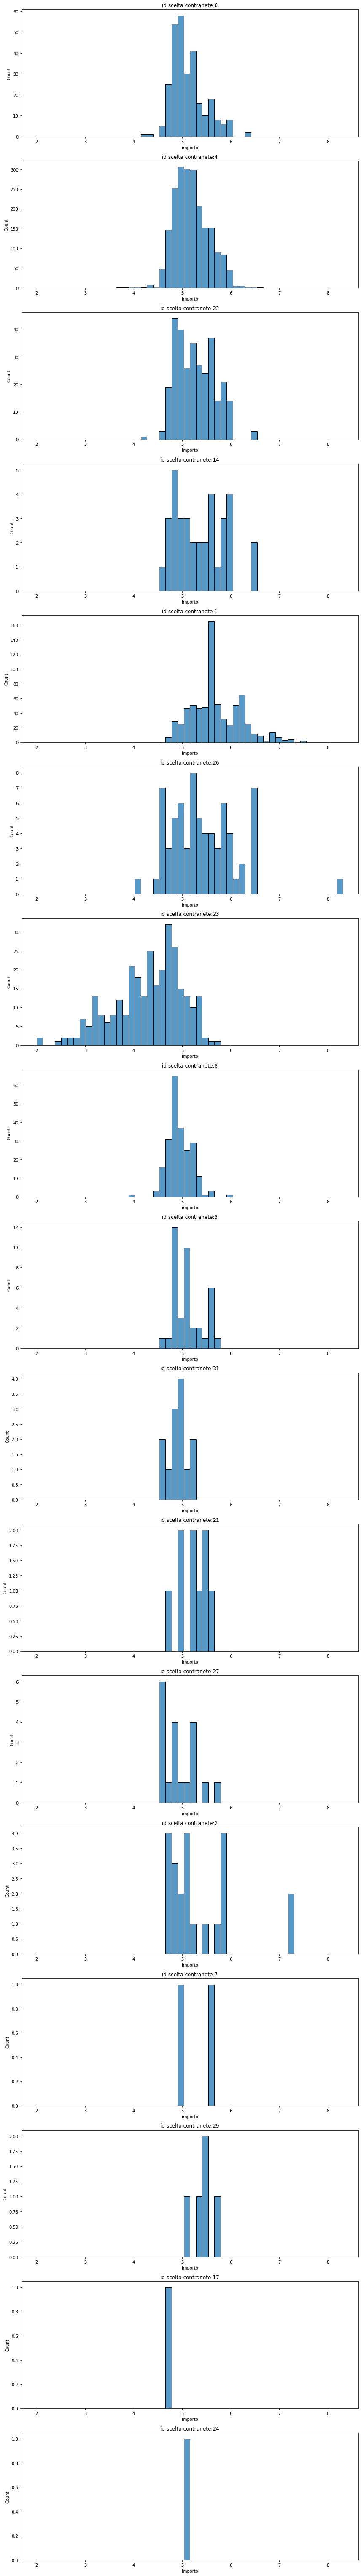

In [23]:
# distribuzioni importo(scelta del contraente)
fig, ax = plt.subplots(len(df.id_scelta_contraente.unique()), 
                       figsize=(6*2,5*len(df.id_scelta_contraente.unique())))
for i, id_scelta_contraente in enumerate(df.id_scelta_contraente.unique()):
    sns.histplot(
        data=log_df[log_df.id_scelta_contraente == id_scelta_contraente], x="importo", 
        ax=ax[i], bins=50, binrange=(log_df.importo.min(), log_df.importo.max()))
    ax[i].set_title(f"id scelta contranete:{id_scelta_contraente}")

plt.tight_layout()

## scatterplot durata-log(importi)

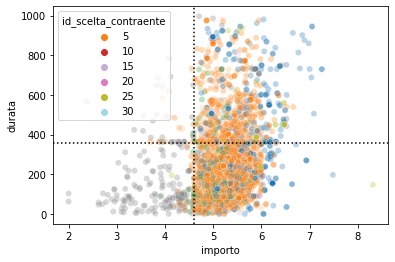

In [33]:
# scatterplot durata(giorni), log(importo)
sns.scatterplot(x=log_df[log_df.durata.dt.days < 1000].importo, 
                y=log_df[log_df.durata.dt.days < 1000].durata.dt.days, 
                alpha=.3, hue=log_df.id_scelta_contraente, palette=plt.get_cmap("tab20"))
plt.axvline(np.log10(40000), color='black', linestyle='dotted')
plt.axhline(356, color='black', linestyle="dotted")

In [25]:
df.id_scelta_contraente.unique().shape

(17,)

<AxesSubplot:xlabel='importo', ylabel='fatturato_mediano_be'>

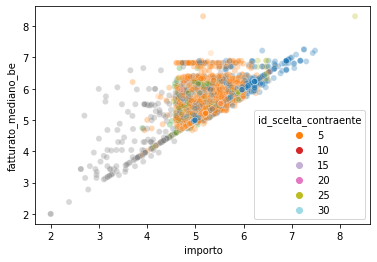

In [26]:
sns.scatterplot(x="importo", y="fatturato_mediano_be", data=log_df, alpha=.3, hue="id_scelta_contraente", palette=plt.get_cmap("tab20"))

bisogna ridurre le classi di forma giuridica

In [27]:
df.id_forma_giuridica_acquirente.unique().shape

(27,)

<AxesSubplot:xlabel='importo', ylabel='fatturato_mediano_be'>

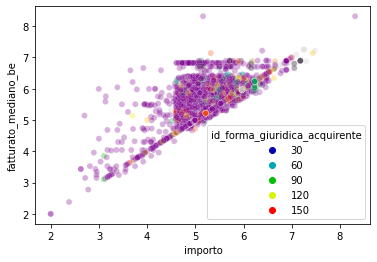

In [28]:
sns.scatterplot(x="importo", y="fatturato_mediano_be", data=log_df, alpha=.3, 
                hue="id_forma_giuridica_acquirente", palette=plt.get_cmap("nipy_spectral"))

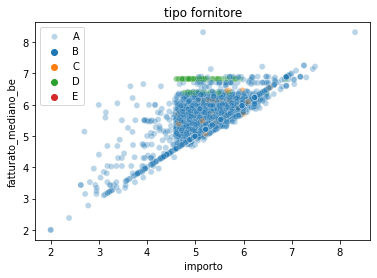

In [29]:
import string
sns.scatterplot(x="importo", y="fatturato_mediano_be", data=log_df, alpha=.3, 
                hue="tipo_fornitore")
plt.legend(string.ascii_uppercase[:len(log_df.tipo_fornitore.unique())])
plt.title("tipo fornitore")
plt.show()

In [30]:
df.id_forma_giuridica_fornitore.unique().shape

(27,)

<AxesSubplot:xlabel='importo', ylabel='fatturato_mediano_be'>

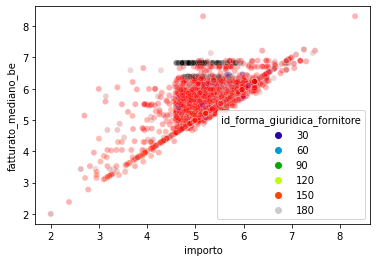

In [31]:
sns.scatterplot(x="importo", y="fatturato_mediano_be", data=log_df, alpha=.3,
                hue="id_forma_giuridica_fornitore", palette=plt.get_cmap("nipy_spectral"))

<AxesSubplot:xlabel='importo', ylabel='fatturato_mediano_cc'>

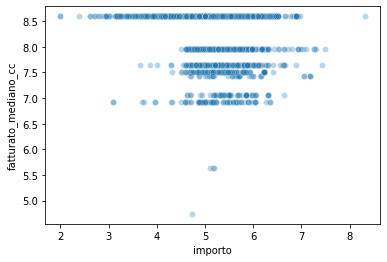

In [32]:
sns.scatterplot(x=log_df.importo, y=log_df.fatturato_mediano_cc, alpha=.3, )

errori: importo, durata
* cifre molto alte con durata breve
* partita come importo
* popolazione del comune
* non mettono la virgola

(togliere accordi quadro perché ridondanti)
accrodi quadro: consip, o regioni, fanno un bando, l'ente pubblico più piccolo deve andare prima da lui previo assenso del vincitore ("adesione"). alcune volte non esiste vincitore ma graduatoria tra vincitori 
adesione è programmazione di spesa

split: dimensione pubbliche amministrazioni (fatturato mediano annuo), macro aree (sanità, ...), no cpv bensì 

classi: affidamento diretto, procedura negoziata (l'acquirente non sa bene chi può fornire un tal bene, manifestazione di interesse con numero minimo di partecipanti, etc), (no procedure ristretta), procedure aperta (capitolato etc), 
rilevanza: importo decrescete, procedura aperta

i comuni piccoli non fanno grandi investimenti, bensì cuc (centrale unica di committenza) province e regioni -> stazioni unica di appalto. l'ipotesi è che abbiano dinamiche di acquisto diverse. 

feature o nuovo modello?
feature: procedura, fatturato mediano annuo, 